# 基于PSPNet的人体解析

[项目链接](https://aistudio.baidu.com/aistudio/projectdetail/4210435)

## 导入包

In [2]:
import paddle
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

## 模型PSPNet

### ConvBNReluLayer
该类封装`卷积`、`批归一化`、`ReLU`，方便代码的复用。

In [4]:
class ConvBNReluLayer(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1, groups = 1, dilation = 1, padding = None, name = None):
        super(ConvBNReluLayer, self).__init__(name)
        if padding is None:
            padding = (kernel_size - 1) // 2
        self.conv = paddle.nn.Conv2D(in_channels = in_channels, 
            out_channels = out_channels,
            kernel_size = kernel_size,
            stride = stride,
            padding = padding,
            groups = groups,
            dilation = dilation)
        self.bn = paddle.nn.BatchNorm2D(num_features=out_channels)
        self.relu - paddle.nn.ReLU()


    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)

        return x

### BottleneckBlock
该类封装了`ResNet`层数大于等于`50`用的代码块，结构如下图: 

包括`3`次`卷积`操作和`1`次`元素相加`操作；

元素相加 : 最开始的输入与最后的输出相加，当输入和输出的通道数不匹配时，会进行`1x1卷积`操作，进行维度匹配。


![](https://ai-studio-static-online.cdn.bcebos.com/ee98071a356e413781e71907b0670ae707b09ba386f54b5baae5f85ed512d6e7)


In [6]:
class BottleneckBlock(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels, stride = 1, shortcut = True, dilation = 1, padding = None, name = None):
        super(BottleneckBlock, self).__init__(name)

        self.conv0 = ConvBNReluLayer(in_channels = in_channels, out_channels= out_channels, kernel_size = 1)
        self.conv1 = ConvBNReluLayer(in_channels = in_channels, out_channels= out_channels, kernel_size= 3, stride= stride, padding= padding, dilation= dilation)
        self.conv2 = ConvBNReluLayer(in_channels = in_channels, out_channels = out_channels*4, kernel_size = 1, stride = 1)

        if not shortcut:
            self.short - ConvBNReluLayer(in_channels = in_channels, out_channels= out_channels*4, kernel_size=1, stride = stride)
        self.shortcut = shortcut
        self.num_channel_out = out_channels * 4
    
    def forward(self, inputs):
        conv0 = self.conv0(inputs)
        conv1 = self.conv1(conv0)
        conv2 = self.conv2(conv1)
        if self.shortcus:
            short = inputs
        else:
            short = self.short(inputs)
        
        y = paddle.add(x = short, y = conv2)
        y = paddle.nn.functional.relu(x = y)
        return y        

### Dilated Resnet50
该类封装了 Dilated Resnet50 的代码，具体结构类似如下图，把原始 ResNet 的一些卷积操作改为了空洞卷积。

卷积计算：

![](https://ai-studio-static-online.cdn.bcebos.com/b5f7735bd8ad4f20b1ecc2e9e8afc9ade7c24db98d3a4eadba483a27bc01ae90)


该类结构从上到下包括:

* 卷积核大小为7x7，卷积核通道数为64，步长为2的卷积操作
* 池化核大小为3x3，步长为2的最大池化层
* 16个 BottleneckBlock (4种，个数分别为3，4，6，3)
* 全局平均池化
* 全连接层

![](https://ai-studio-static-online.cdn.bcebos.com/896b5aad6ffa4c999d10f1d812d7ecfd4e3056e37d35483bb7c009ac5450800a)


In [11]:
class DilatedResnet50(paddle.nn.Layer):
    def __init__(self, block=BottleneckBlock, num_classes=1000):
        super(DilatedResnet50, self).__init__()
        deepth = [3, 4, 6, 3]
        num_channels = [64, 128, 512, 1024]
        num_filters = [64, 128, 256, 512]
        self.conv = ConvBNReluLayer(in_channels = 3, out_channels = 64, kernel_size = 7, stride = 2)
        self.pool2d_max = paddle.nn.MaxPool2D(kernel_size = 3, stride = 2, padding = 1)
        l1_shortcut = False
        self.layer1 = paddle.nn.Sequential(
            *self.make_layer(
                block,
                num_channels[0],
                num_filters[0],
                depth[0],
                stride = 1,
                shortcut = l1_shortcut,
                name = 'layer1'
            )
        )
        self.layer2 = paddle.nn.Sequential(
            *self.make_layer(
                block,
                num_channels[1],
                num_filters[1],
                depth[1],
                stride = 2,
                name = 'layer2'
            )
        )
        self.layer3 = paddle.nn.Sequential(
            *self.make_layer(
                block,
                num_channels[2],
                num_filters[2],
                depth[2],
                stride = 1,
                name = 'layer3',
                dilation = 2
            )
        )
        self.layer4 = paddle.nn.Sequential(
            *self.make_layer(
                block,
                num_channels[3],
                num_filters[3],
                depth[3],
                stride = 1,
                name = 'layer4',
                dilation = 4
            )
        ) 
        
        self.last_pool = paddle.nn.AdaptiveAvgPool2D(output_size=(1, 1))
        self.out_dim = num_filters[-1] * block.expansion
        self.fc = paddle.nn.Linear(in_features=num_filters[-1] * block.expansion, out_features=num_classes)

    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.pool2d_max(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.last_pool(x)
        x = paddle.reshape(x, shape[-1, self.out_dim])
        x = self.fc(x)

        return x

    def make_layer(self, block, in_channels, out_channels, depth, stride, dilation=1, shortcut=False, name=None):
        """
        用于生成4种BottleneckBlock
        block: BottleneckBlock
        depth: 该种BottleneckBlock的个数
        """
        layers = paddle.nn.LayerList()
        if dilation > 1:
            padding = dilation
        else:
            padding = None
        
        layers.append(block(
            in_channels = in_channels,
            out_channels = out_channels,
            stride = stride,
            shortcut = shortcut,
            dilation = dilation,
            padding = padding,
            name = f'{name}.0'
        ))
        for i in range(1, depth):
            layers.append(block(
                in_channels = out_channels * block.expansion,
                out_channels = out_channels,
                stride = 1,
                dilation = dilation,
                padding = padding,
                name = f'{name}.{i}'
            ))
        return layers

        

### PSPModule
该类封装了金字塔池化模块，结构如下图。

该类操作包括:
* 将输入为 NCHW 特征图变成4个 HW 不同的特征图(1x1、2x2、3x3、6x6)
* 通过 1x1 的卷积给4个不同的特征图进行降维
* 将4个不同的特征图通过上采样变为输入特征图大小
* 将输入特征图和4个经过上采样后的特征图进行拼接

![](https://ai-studio-static-online.cdn.bcebos.com/d78f9a412b6d49a18b9e0ae1aee73d0abbfc81dd49b648849ff22e131b730f54)


In [13]:
class PSPModule(paddle.nn.Layer):
    def __init__(self, in_channels, bin_size_list):
        """
        bin_size_list: 不同池化, 例如, 将输入为 NCHW 特征图变成4个 HW 不同的特征图(1x1、2x2、3x3、6x6), 
                       则bin_size_list=[1, 2, 3, 6]
        """
        super(PSPModule, self).__init__()
        out_channels = in_channels // len(bin_size_list)
        self.features = paddle.nn.LayerList()
        for i in range(len(bin_size_list)):
            self.features.append(
                paddle.nn.Sequential(
                    paddle.nn.AdaptiveAvgPool2D(output_size = bin_size_list[i]),
                    paddle.nn.Conv2D(in_channels = in_channels, out_channels=out_channels, kernel_size = (1, 1)),
                    paddle.nn.BatchNorm2D(num_features = out_channels)
                )
            )
        

    def forward(self, inputs):
        out = [inputs]
        for idx, f in enumerate(self.features):
            x = paddle.nn.functional.interpolate(x = x, size = inputs.shape[2::], mode = 'bilinear', align_corners=True)
            out.append(x)
        
        out = paddle.concat(x = out, axis = 1)
        return out

### PSPNet
该类封装了整个PSPNet网络,用于进行图像分割,结构如下图。

该类包括:
* Dilated Resnet50 平均池化层以前的操作
* 金字塔模块
* 进行像素点分类的卷积操作

![](https://ai-studio-static-online.cdn.bcebos.com/9f73010652df4a228547e587fcb2af3e1694b884489a480fad051c393b11eb7b)


In [15]:
class PSPNet(paddle.nn.Layer):
    def __init__(self, backbone='DilatedResnet50', num_classes=20):
        """
        num_classes: 分类类别
        """
        super(PSPNet, self).__init__()
        res = DilatedResnet50()
        self.layers = paddle.nn.Sequential(
            res.conv,
            res.pool2d_max,
            res.layer1,
            res.layer2,
            res.layer3,
            res.layer4,
        )
        self.pspmodule = PSPModule(in_channels=in_channels, bin_size_list = [1, 2, 3, 6])
        in_channels *= 2
        self.classifier = paddle.nn.Sequential(
            paddle.nn.Conv2D(in_channels = in_channels, out_channels=512, kernel_size = 3, padding = 1),
            paddle.nn.BatchNorm2D(num_features=512),
            paddle.nn.ReLU(),
            paddle.nn.Dropout(0.1),
            paddle.nn.Conv2D(in_channel = 512, out_channels= num_classes, kernel_size=1)
        )

    def forward(self, inputs):
        x = self.layers(inputs)
        x = self.pspmodule(x)
        x = self.classifier(x)
        x = paddle.nn.functional.interpolate(x = x, size = inputs.shapr[2::], moudle = 'bilinear', align_corners = True)
        return x
       

In [16]:
# 打印模型结构
paddle.summary(PSPNet(), (-1, 3, 600, 400))

AttributeError: 'ConvBNReluLayer' object has no attribute 'relu'

## 数据准备和处理
### 解压数据集

In [ ]:
!unzip data/data156387/humanparsing.zip -d data/

### 划分数据集
* JPEGImages : 原图文件夹
* SegmentationClassAug : 分割图文件夹
* 图片编号一一对应, 原图.jpg, 分割图.png

In [9]:
data = []
path1 = 'data/humanparsing/JPEGImages'
path2 = 'data/humanparsing/SegmentationClassAug'

for item in os.listdir(path1):
    data.append([
        os.path.join(path1, item), # 原图路径
        os.path.join(path2, item.split('.')[0] + '.png') # 分割图路径
    ])

# 打乱数据集
np.random.shuffle(data)
# 划分训练集和验证集
train_data = data[len(data)//10:]
val_data = data[:len(data)//10]
# 将路径写入.txt文件
def write_path(data, path):
    with open(path, 'w') as f:
        for item in tqdm(data):
            f.write(item[0] + ' ' + item[1] + '\n') # 原图路径 分割图路径

write_path(train_data, 'train.txt')
write_path(val_data, 'val.txt')

100%|██████████| 1770/1770 [00:00<00:00, 979925.83it/s]


2022-07-10 17:12:18,156 - WARNING - No handles with labels found to put in legend.


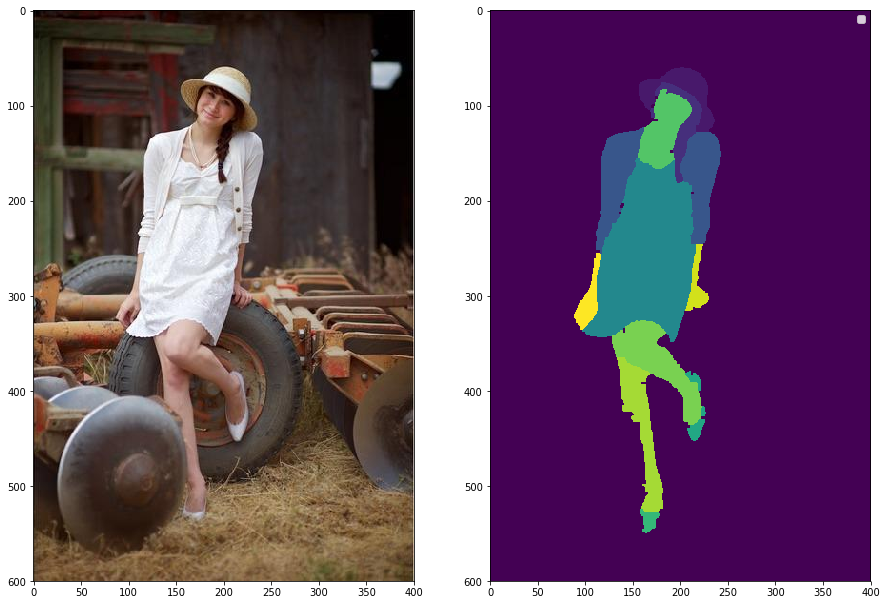

2022-07-10 17:12:18,706 - WARNING - No handles with labels found to put in legend.


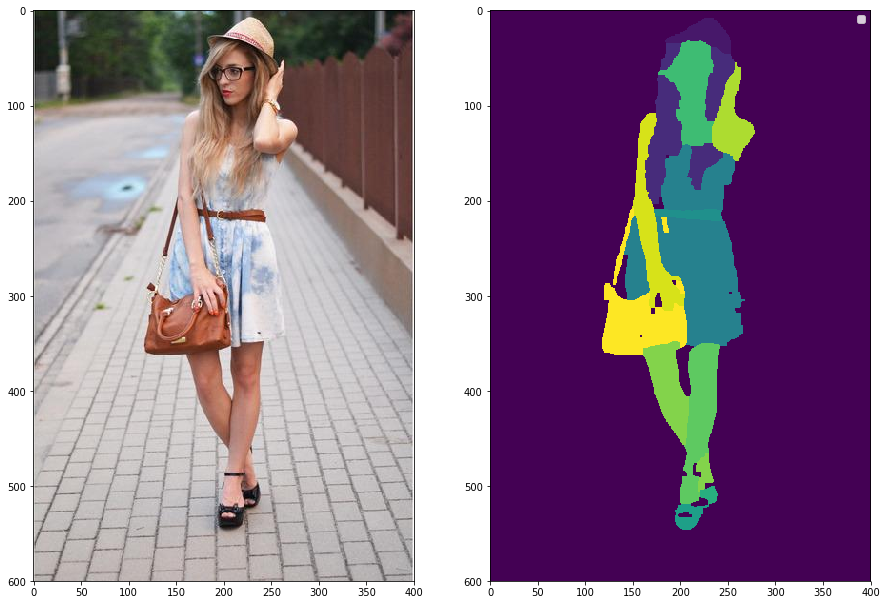

In [11]:
# 画图
def draw(img_list, name=None):
    plt.figure(figsize=(15, 15))
    for i in range(len(img_list)):
        plt.subplot(1, len(img_list), i+1)
        plt.imshow(img_list[i])
        if name:
            plt.title(name[i])
    plt.legend()
    plt.show()

# 查看数据
img1 = cv2.cvtColor(cv2.imread('data/humanparsing/JPEGImages/2500_1001.jpg'), cv2.COLOR_BGR2RGB) # BGR -> RGB
img2 = cv2.imread('data/humanparsing/SegmentationClassAug/2500_1001.png')[..., 0]
draw([img1, img2])

img3 = cv2.cvtColor(cv2.imread('data/humanparsing/JPEGImages/dataset10k_875.jpg'), cv2.COLOR_BGR2RGB) # BGR -> RGB
img4 = cv2.imread('data/humanparsing/SegmentationClassAug/dataset10k_875.png')[..., 0]
draw([img3, img4])

### 自定义数据集类
在自定义数据集类的时候，如有数据增强操作，由于是进行的分割，所有图像和标签要进行相同的操作。

In [12]:
class MyDataset(paddle.io.Dataset):
    def __init__(self, mode, img_size=(600, 400)):
        super(MyDataset, self).__init__()
        

    def __getitem__(self, idx):
        

    def __len__(self):
        
    
    def __transform(self, img, label):
        flag = np.random.random()
        if flag < 0.1:
            angle = np.random.randint(360)
            # 旋转
            img = paddle.vision.transforms.rotate(img=img, angle=angle)
            label = paddle.vision.transforms.rotate(img=label, angle=angle)
            padding = [0, 0, 0, 0]
            top = np.random.randint(self.img_size[0])
            left = np.random.randint(self.img_size[1])
            padding[2] = left
            padding[3] = top
            # 裁剪
            img = paddle.vision.transforms.crop(img=img, top=top, left=left, height=self.img_size[0], width=self.img_size[1])
            label = paddle.vision.transforms.crop(img=label, top=top, left=left, height=self.img_size[0], width=self.img_size[1])
            # 填充
            img = paddle.vision.transforms.pad(img=img, padding=padding)
            label = paddle.vision.transforms.pad(img=label, padding=padding)
        return img, label


2022-07-10 17:13:05,235 - WARNING - No handles with labels found to put in legend.


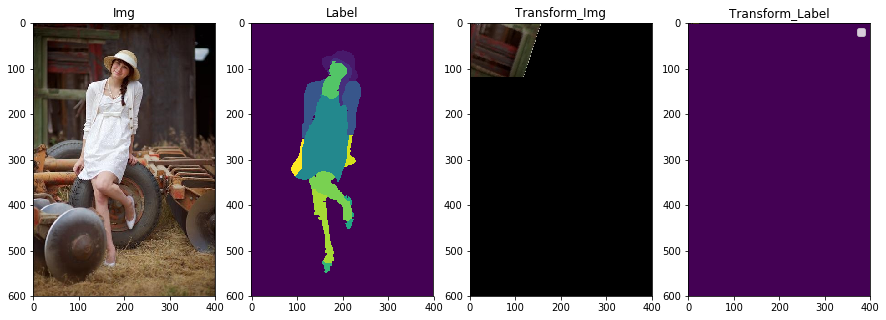

2022-07-10 17:13:05,712 - WARNING - No handles with labels found to put in legend.


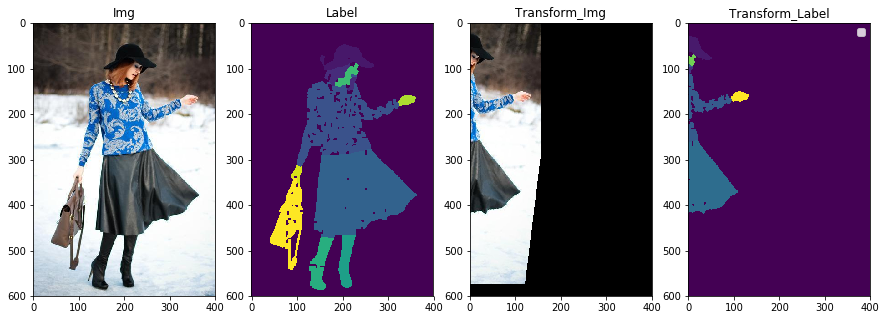

In [14]:
# 数据增强效果演示
img_size = (600, 400)
def t(img, label):
    """
    将自定义数据集里增强操作拿出来用一下
    """
    angle = np.random.randint(360)
    # 旋转
    img = paddle.vision.transforms.rotate(img=img, angle=angle)
    label = paddle.vision.transforms.rotate(img=label, angle=angle)
    padding = [0, 0, 0, 0]
    top = np.random.randint(img_size[0])
    left = np.random.randint(img_size[1])
    padding[2] = left
    padding[3] = top
    # 裁剪
    img = paddle.vision.transforms.crop(img=img, top=top, left=left, height=img_size[0], width=img_size[1])
    label = paddle.vision.transforms.crop(img=label, top=top, left=left, height=img_size[0], width=img_size[1])
    # 填充
    img = paddle.vision.transforms.pad(img=img, padding=padding)
    label = paddle.vision.transforms.pad(img=label, padding=padding)
    return img, label

# 画图
def draw(img_list, name=None):
    plt.figure(figsize=(15, 15))
    for i in range(len(img_list)):
        plt.subplot(1, len(img_list), i+1)
        plt.imshow(img_list[i])
        if name:
            plt.title(name[i])
    plt.legend()
    plt.show()

# 查看数据
img1 = cv2.cvtColor(cv2.imread('data/humanparsing/JPEGImages/2500_1001.jpg'), cv2.COLOR_BGR2RGB) # BGR -> RGB
mask1 = cv2.imread('data/humanparsing/SegmentationClassAug/2500_1001.png')
t_img1, t_mask1 = t(img1, mask1)
draw([img1, mask1[..., 0], t_img1, t_mask1[..., 0]], ['Img', 'Label', 'Transform_Img', 'Transform_Label'])

img2 = cv2.cvtColor(cv2.imread('data/humanparsing/JPEGImages/4565_875.jpg'), cv2.COLOR_BGR2RGB) # BGR -> RGB
mask2 = cv2.imread('data/humanparsing/SegmentationClassAug/4565_875.png')
t_img2, t_mask2 = t(img2, mask2)
draw([img2, mask2[..., 0], t_img2, t_mask2[..., 0]], ['Img', 'Label', 'Transform_Img', 'Transform_Label'])

In [15]:
# 测试自定义数据集读取情况
dataset = MyDataset(mode='train')
img, label = dataset[0]
print(img.shape, label.shape)

(3, 600, 400) (600, 400)


## MIOU
> * 评价图像分割效果的指标
> * 分割每一类别的交并比（IOU）

In [16]:
import numpy as np

class IOUMetric:
    """
    Class to calculate mean-iou using fast_hist method
    """

    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.hist = np.zeros((num_classes, num_classes))

    def _fast_hist(self, label_pred, label_true):
        # 找出标签中需要计算的类别,去掉了背景
        mask = (label_true >= 0) & (label_true < self.num_classes)
        # # np.bincount计算了从0到n**2-1这n**2个数中每个数出现的次数，返回值形状(n, n)
        hist = np.bincount(
            self.num_classes * label_true[mask].astype(int) +
            label_pred[mask], minlength=self.num_classes ** 2).reshape(self.num_classes, self.num_classes)
        return hist

    # 输入：预测值和真实值
    # 语义分割的任务是为每个像素点分配一个label
    def evaluate(self, predictions, gts):
        for lp, lt in zip(predictions, gts):
            assert len(lp.flatten()) == len(lt.flatten())
            self.hist += self._fast_hist(lp.flatten(), lt.flatten())
            
        # miou
        iou = np.diag(self.hist) / (self.hist.sum(axis=1) + self.hist.sum(axis=0) - np.diag(self.hist))
        miou = np.nanmean(iou) 

        return miou

## 常用的函数

In [17]:
if os.path.exists('work/save_model') == False:
    os.mkdir('work/save_model')

# 保存模型参数
def save_model(model, model_name):
    print('{} model saving...'.format(model_name))
    paddle.save(model.state_dict(), 'work/save_model/{}.pdparames'.format(model_name))

# 读取模型参数
def load_model(model, model_name):
    if os.path.exists('work/save_model/{}.pdparames'.format(model_name)) == False:
        print('No {} model pdparames...'.format(model_name))
    else:
        model.set_state_dict(paddle.load('work/save_model/{}.pdparames'.format(model_name)))
        print('success loading {} model pdparames'.format(model_name))

# 保存指标列表
def save_miou_loss(data_list, name):
    with open(name+'.txt', 'a') as f:
        for data in data_list:
            f.write(str(data) + '\n')

# 读取保存在文件的指标
def read_miou_loss(name):
    data_list = []
    with open(name+'.txt', 'r') as f:
        for data in f.readlines():
            data_list.append(eval(data.strip()))
    return data_list

## DataLoader
> * 用于模型训练、验证
> * 每次返回一个batch的数据

In [18]:
# 数据集
train_dataset = MyDataset(mode='train')
val_dataset = MyDataset(mode='val')
# dataloader
batch_size = 4
train_loader = paddle.io.DataLoader(dataset=train_dataset, batch_size=batch_size, places=paddle.CUDAPlace(0), shuffle=True, drop_last=True)
val_loader = paddle.io.DataLoader(dataset=val_dataset, batch_size=batch_size, places=paddle.CUDAPlace(0), shuffle=True, drop_last=True)

In [19]:
# 测试dataloader
count = 0
for (img, label) in train_loader:
    print(img.shape, label.shape)
    count += 1
    if count == 10:
        break

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(slot[0], (np.ndarray, np.bool, numbers.Number)):


[4, 3, 600, 400] [4, 600, 400]
[4, 3, 600, 400] [4, 600, 400]
[4, 3, 600, 400] [4, 600, 400]
[4, 3, 600, 400] [4, 600, 400]
[4, 3, 600, 400] [4, 600, 400]
[4, 3, 600, 400] [4, 600, 400]
[4, 3, 600, 400] [4, 600, 400]
[4, 3, 600, 400] [4, 600, 400]
[4, 3, 600, 400] [4, 600, 400]
[4, 3, 600, 400] [4, 600, 400]


## 模型声明

In [20]:
num_classes = 20
model_name = 'PSPNet'
model = PSPNet(num_classes=num_classes)
# 优化器
optimizer = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
# 损失函数
loss = paddle.nn.CrossEntropyLoss(axis=1)
# 分割效果指标
miou = IOUMetric(num_classes=num_classes)

# 模型加载
load_model(model=model, model_name=model_name)

success loading PSPNet model pdparames


## 模型训练

In [ ]:
epochs = 1
train_loss_list = []
train_miou_list = []
val_loss_list = []
val_miou_list = []
print('Start Training...')
for epoch in range(1, epochs+1):
    print('Epoch/Epochs:{}/{}'.format(epoch, epochs))

    print('Train...')
    train_loss = 0
    train_miou = 0
    model.train()
    for batch_id, (img, label) in enumerate(train_loader):
        optimizer.clear_grad()
        pred = model(img)
        step_loss = loss(pred, label)
        train_loss += step_loss.numpy()[0]
        # 计算miou, pred: num_loss * NCHW -> NHW 
        mask = np.argmax(pred.numpy(), axis=1)
        step_miou = 0
        for i in range(mask.shape[0]):
            # print(mask[i].shape, label.shape)
            step_miou += miou.evaluate(mask[i], label.numpy()[i])
        step_miou /= mask.shape[0]
        train_miou += step_miou
        step_loss.backward()
        optimizer.step()
        # 打印信息
        if (batch_id + 1) % 50 == 0:
           print('Epoch/Epochs:{}/{} Batch/Batchs:{}/{} Step Loss:{} Step Miou:{}'.format(epoch, epochs, batch_id+1, len(train_loader), \
                                                                                            step_loss.numpy(), step_miou))
    
    print('Train Loss:{} Train Miou:{}'.format(train_loss/len(train_loader), train_miou/len(train_loader)))
    train_loss_list.append(train_loss/len(train_loader))
    train_miou_list.append(train_miou/len(train_loader))

    print('Val...')
    val_loss = 0
    val_miou = 0
    model.eval()
    for batch_id, (img, label) in tqdm(enumerate(val_loader)):
        pred = model(img)
        step_loss = loss(pred, label)
        val_loss += step_loss.numpy()[0]
        # 计算miou, pred: num_loss * NCHW -> NHW 
        mask = np.argmax(pred.numpy(), axis=1)
        step_miou = 0
        for i in range(mask.shape[0]):
            # print(mask[i].shape, label.shape)
            step_miou += miou.evaluate(mask[i], label.numpy()[i])
        step_miou /= mask.shape[0]
        val_miou += step_miou

    print('Val Loss:{} Val Miou:{}'.format(val_loss/len(val_loader), val_miou/len(val_loader)))
    val_loss_list.append(val_loss/len(val_loader))
    val_miou_list.append(val_miou/len(val_loader))

    save_model(model, model_name)

print('Train Over...')

Start Training...
Epoch/Epochs:1/1
Train...


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


Epoch/Epochs:1/1 Batch/Batchs:50/3984 Step Loss:[0.07190482] Step Miou:0.7654844895839027
Epoch/Epochs:1/1 Batch/Batchs:100/3984 Step Loss:[0.08463134] Step Miou:0.7803400171444888
Epoch/Epochs:1/1 Batch/Batchs:150/3984 Step Loss:[0.05798771] Step Miou:0.7741561411386673
Epoch/Epochs:1/1 Batch/Batchs:200/3984 Step Loss:[0.03952862] Step Miou:0.7778326136661887
Epoch/Epochs:1/1 Batch/Batchs:250/3984 Step Loss:[0.07094694] Step Miou:0.7775926183108282
Epoch/Epochs:1/1 Batch/Batchs:300/3984 Step Loss:[0.11193475] Step Miou:0.7773100724751069
Epoch/Epochs:1/1 Batch/Batchs:350/3984 Step Loss:[0.06858622] Step Miou:0.779921697632026
Epoch/Epochs:1/1 Batch/Batchs:400/3984 Step Loss:[0.18903305] Step Miou:0.7812739664484039
Epoch/Epochs:1/1 Batch/Batchs:450/3984 Step Loss:[0.09076664] Step Miou:0.7802513127487902


In [ ]:
# 保存数据
save_miou_loss(train_loss_list, 'train_loss')
save_miou_loss(train_miou_list, 'train_miou')
save_miou_loss(val_loss_list, 'val_loss')
save_miou_loss(val_miou_list, 'val_miou')

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:143: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
2022-07-10 17:14:06,410 - WARNING - No handles with labels found to put in legend.


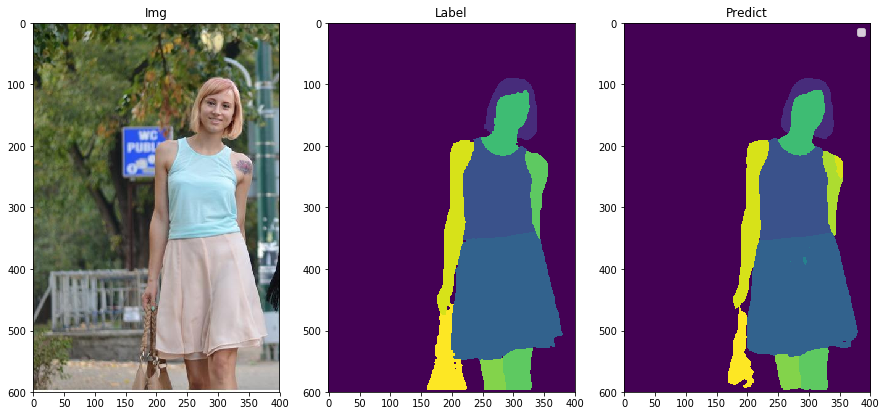

2022-07-10 17:14:06,894 - WARNING - No handles with labels found to put in legend.


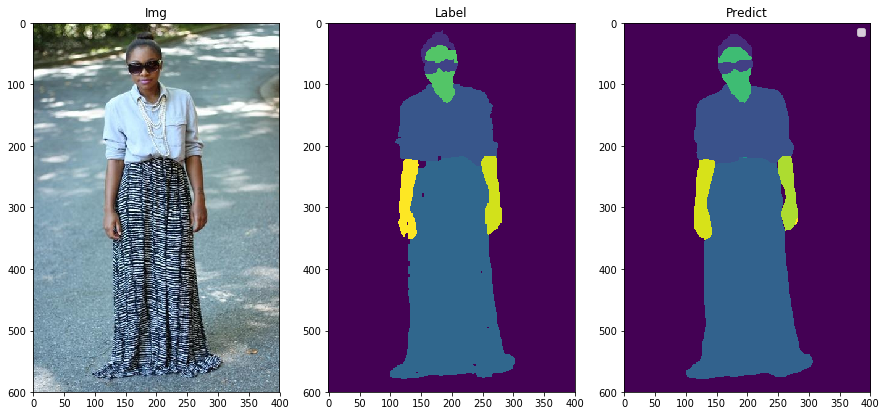

In [22]:
# 获得预测结果
def get_mask(img):
    t = paddle.vision.transforms.Compose([
        paddle.vision.transforms.Transpose((2, 0, 1)), # HWC -> CHW
        paddle.vision.transforms.Normalize(mean=127.5, std=127.5)
    ])
    img1 = paddle.to_tensor([t(img)]) # 输入网络的图片形状为 : NCHW

    pred = model(img1) # NCHW
    mask = np.argmax(pred.numpy(), axis=1) # NCHW -> NHW
    return mask[0]
# 画图
def draw(img_list, name=None):
    plt.figure(figsize=(15, 15))
    for i in range(len(img_list)):
        plt.subplot(1, len(img_list), i+1)
        plt.imshow(img_list[i])
        if name:
            plt.title(name[i])
    plt.legend()
    plt.show()


model.eval()

img1 = cv2.imread('data/humanparsing/JPEGImages/4565_1912.jpg')
label1 = cv2.imread('data/humanparsing/SegmentationClassAug/4565_1912.png', 0)
mask1 = get_mask(img1)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) # BGR -> RGB

img2 = cv2.imread('data/humanparsing/JPEGImages/dataset10k_6890.jpg')
label2 = cv2.imread('data/humanparsing/SegmentationClassAug/dataset10k_6890.png', 0)
mask2 = get_mask(img2)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) # BGR -> RGB

draw([img1, label1, mask1], ['Img', 'Label', 'Predict'])
draw([img2, label2, mask2], ['Img', 'Label', 'Predict'])

## 可视化结果

In [ ]:
def show_list(data, name):
    for i in range(len(data)):
        plt.plot(np.array(data[i]), label=name[i])
    plt.title(name[-1])
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(name[-1] + '.jpg')
    plt.show()

train_loss_list = read_miou_loss('train_loss')
train_miou_list = read_miou_loss('train_miou')
val_loss_list = read_miou_loss('val_loss')
val_miou_list = read_miou_loss('val_miou')
#
show_list(
    [train_loss_list, val_loss_list],
    ['train loss', 'val loss', 'Loss']
)
show_list(
    [train_miou_list, val_miou_list],
    ['train miou', 'val miou', 'Miou']
)

* MIOU

![](https://ai-studio-static-online.cdn.bcebos.com/cb1d4df1df8c45bdaa1cac9630b4775a8007273b56024c4b88d1172a5611cb30)

* Loss

![](https://ai-studio-static-online.cdn.bcebos.com/3f4a5a93364148878a12a8bca551f5dd653b255f79e64044b12e1821f82ee9cd)


## 模型测试
* 需要训练好的参数,效果才比较好

success loading PSPNet model pdparames


2022-07-10 17:18:24,145 - WARNING - No handles with labels found to put in legend.


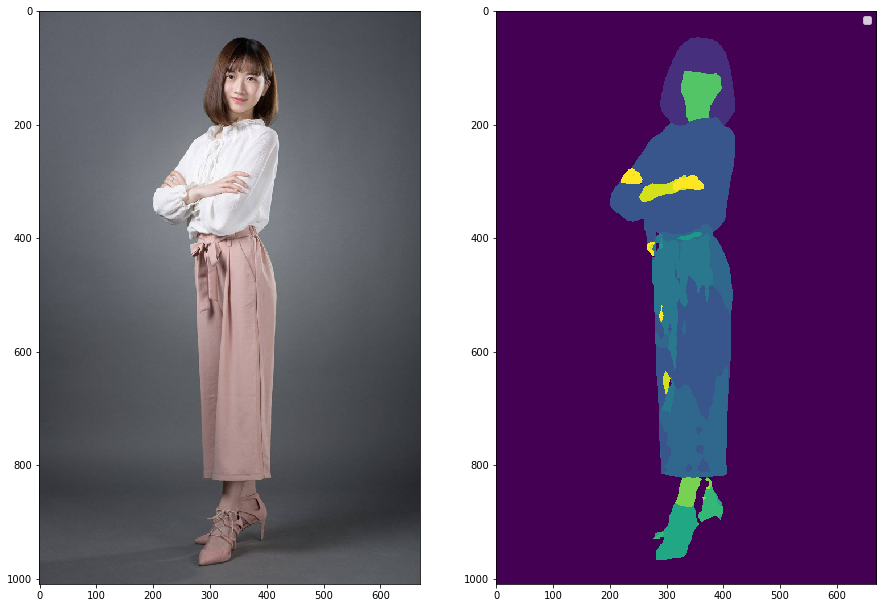

In [24]:
# 获得预测结果
def get_mask(img):
    t = paddle.vision.transforms.Compose([
        paddle.vision.transforms.Transpose((2, 0, 1)), # HWC -> CHW
        paddle.vision.transforms.Normalize(mean=127.5, std=127.5)
    ])
    img1 = paddle.to_tensor([t(img)]) # 输入网络的图片形状为 : NCHW

    pred = model(img1) # NCHW
    mask = np.argmax(pred.numpy(), axis=1) # NCHW -> NHW
    return mask[0]

# 画图
def draw(img_list, name=None):
    plt.figure(figsize=(15, 15))
    for i in range(len(img_list)):
        plt.subplot(1, len(img_list), i+1)
        plt.imshow(img_list[i])
        if name:
            plt.title(name[i])
    plt.legend()
    plt.show()
    
# 读取模型
num_classes=20
model_name = 'PSPNet'
model = PSPNet(num_classes=num_classes)
# 模型加载
load_model(model=model, model_name=model_name)
model.eval()
# 预测
tsy_img = cv2.imread('demo.png')
tsy_mask = get_mask(tsy_img)
draw(
    [cv2.cvtColor(tsy_img, cv2.COLOR_BGR2RGB), tsy_mask]
)